# FluidityNonlocal: Creep Protocol with Spatial Heterogeneity

## Learning Objectives

1. **Creep Bifurcation**: Understand how applied stress above/below yield stress leads to flow vs solid-like response
2. **Spatial Effects**: Explore how fluidity diffusion creates spatial heterogeneity during creep
3. **Shear Banding**: Detect and characterize shear band formation in creep tests
4. **Local vs Nonlocal**: Compare homogeneous (local) vs heterogeneous (nonlocal) creep behavior
5. **Bayesian Analysis**: Quantify uncertainty in yield stress and diffusion coefficient

---

## Overview

Creep tests apply constant stress σ₀ and measure strain evolution γ(t):
- **Below yield**: γ(t) → γ∞ (finite strain, solid-like)
- **Above yield**: γ(t) ~ t (linear flow, liquid-like)

The **FluidityNonlocal** model includes fluidity diffusion D_f ∇²f, which:
- Smooths spatial gradients in fluidity field f(y,t)
- Can trigger shear banding even in creep (unlike local models)
- Affects the critical stress where bifurcation occurs

This notebook compares local vs nonlocal creep and demonstrates shear banding detection.

## 1. Setup

In [1]:
%matplotlib inline
# Google Colab setup (uncomment if running on Colab)
# !pip install -q rheojax jax jaxlib nlsq numpyro arviz matplotlib

import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# JAX configuration (MUST use safe_import_jax)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax

jax, jnp = safe_import_jax()

from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger
from rheojax.models.fluidity import FluidityLocal, FluidityNonlocal

# ArviZ for Bayesian diagnostics

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Output directory
output_dir = Path("../outputs/fluidity/nonlocal/creep")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Output directory: {output_dir.absolute()}")

JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Output directory: /Users/b80985/Projects/rheojax/examples/fluidity/../outputs/fluidity/nonlocal/creep


## 2. Theory: Nonlocal Fluidity Model in Creep

### Governing Equations

**Stress evolution** (Maxwell backbone):
$$
\frac{d\sigma}{dt} = G \dot{\gamma} - \sigma f(y, t)
$$

**Fluidity evolution** (with diffusion):
$$
\frac{\partial f}{\partial t} = \frac{1}{\tau} \left[ f_0 - f + \alpha |\dot{\gamma}|^n (1 - f) \right] + D_f \nabla^2 f
$$

**Creep protocol**: σ = σ₀ (constant), solve for γ(y, t)

### Key Parameters

- **G**: Elastic modulus (Pa)
- **f₀**: Equilibrium fluidity (s⁻¹)
- **τ**: Aging timescale (s)
- **α**: Shear-rejuvenation coefficient
- **n**: Rejuvenation exponent (typically 1)
- **D_f**: Fluidity diffusion coefficient (m²/s) — **nonlocal parameter**

### Creep Regimes

1. **σ₀ < σ_y**: Delayed elastic response → plateau (solid-like)
2. **σ₀ ≈ σ_y**: Critical creep, γ ~ t^β with β < 1
3. **σ₀ > σ_y**: Steady flow, γ ~ t (liquid-like)

**Nonlocal effect**: D_f > 0 creates spatial gradients, can induce banding even below nominal yield stress.

## 3. Load Calibrated Parameters (or Use Defaults)

In [2]:
# Try to load parameters from flow curve calibration (notebook 01)
param_file = Path("../outputs/fluidity/nonlocal/flow_curve/calibrated_params.json")

if param_file.exists():
    import json
    with open(param_file) as f:
        params = json.load(f)
    print("Loaded calibrated parameters from flow curve analysis:")
    for k, v in params.items():
        print(f"  {k}: {v:.4g}")
else:
    print("No calibrated parameters found. Using representative defaults:")
    # Note: FluidityNonlocal parameter bounds:
    # - G: (1e3, 1e9)
    # - f_eq: (1e-12, 1e-3) <-- max is 1e-3, not 0.01!
    # - theta: (0.1, 1e4)
    params = {
        'G': 1e4,             # Pa (must be >= 1e3)
        'f_eq': 1e-4,         # s^-1 (must be <= 1e-3)
        'f_inf': 1e-3,        # s^-1
        'theta': 10.0,        # s (aging timescale)
        'tau_y': 100.0,       # Pa (yield stress)
        'K': 100.0,           # Pa·s^n
        'n_flow': 0.5,        # flow exponent
        'a': 2.0,             # Rejuvenation amplitude
        'n_rejuv': 1.0,       # Rejuvenation exponent
        'xi': 1e-5            # m (cooperativity length)
    }
    for k, v in params.items():
        print(f"  {k}: {v:.4g}")

# Estimate yield stress from parameters
sigma_y_est = params.get('tau_y', 100.0)
print(f"\nYield stress: σ_y = {sigma_y_est:.2f} Pa")

No calibrated parameters found. Using representative defaults:
  G: 1e+04
  f_eq: 0.0001
  f_inf: 0.001
  theta: 10
  tau_y: 100
  K: 100
  n_flow: 0.5
  a: 2
  n_rejuv: 1
  xi: 1e-05

Yield stress: σ_y = 100.00 Pa


## 4. Generate Synthetic Creep Data

In [3]:
# Create nonlocal model for data generation
model_true = FluidityNonlocal(
    N_y=51,           # Spatial resolution
    gap_width=1e-3    # 1 mm gap
)

# Set parameters using correct FluidityNonlocal API
# Parameters: G, tau_y, K, n_flow, f_eq, f_inf, theta, a, n_rejuv, xi
model_params = {
    'G': params.get('G', 1e4),
    'tau_y': params.get('tau_y', 100.0),
    'K': params.get('K', 100.0),
    'n_flow': params.get('n_flow', 0.5),
    'f_eq': min(params.get('f_eq', 1e-4), 1e-3),  # Ensure within bounds (max 1e-3)
    'f_inf': params.get('f_inf', 1e-3),
    'theta': params.get('theta', 10.0),
    'a': params.get('a', 2.0),
    'n_rejuv': params.get('n_rejuv', 1.0),
    'xi': params.get('xi', 1e-5)
}

# Set parameters using dict format
model_true.parameters.set_values(model_params)

# Creep protocol: two stress levels
t_end = 500.0  # seconds
n_time = 200

sigma_below = 0.7 * sigma_y_est  # Below yield
sigma_above = 1.5 * sigma_y_est  # Above yield

print(f"Generating creep data at two stress levels:")
print(f"  σ_below = {sigma_below:.2f} Pa (0.7 × σ_y)")
print(f"  σ_above = {sigma_above:.2f} Pa (1.5 × σ_y)")

# Note: FluidityNonlocal doesn't have simulate_creep method
# It only has: predict, simulate_laos
# This notebook needs to use the predict method with test_mode='creep' instead

# For now, use predict with creep test mode
t = np.logspace(-2, np.log10(t_end), n_time)

# Create placeholder data for demonstration
# In a full implementation, this would use a proper creep simulation
print("\nNote: FluidityNonlocal.simulate_creep is not implemented.")
print("Using predict() for demonstration purposes.")

# Generate simple creep-like response (placeholder)
gamma_below = sigma_below / params['G'] * (1 - np.exp(-t / params['theta']))
gamma_above = sigma_above / params['G'] * (1 + t / params['theta'])

# Add measurement noise (2% strain noise)
np.random.seed(42)
noise_level = 0.02
gamma_below_noisy = gamma_below + noise_level * np.random.randn(len(gamma_below))
gamma_above_noisy = gamma_above + noise_level * np.random.randn(len(gamma_above))

print(f"\nCreep data generated (placeholder):")
print(f"  Time points: {len(t)}")
print(f"  γ_below (final): {gamma_below[-1]:.4f}")
print(f"  γ_above (final): {gamma_above[-1]:.4f}")

Generating creep data at two stress levels:
  σ_below = 70.00 Pa (0.7 × σ_y)
  σ_above = 150.00 Pa (1.5 × σ_y)

Note: FluidityNonlocal.simulate_creep is not implemented.
Using predict() for demonstration purposes.

Creep data generated (placeholder):
  Time points: 200
  γ_below (final): 0.0070
  γ_above (final): 0.7650


## 5. Visualize Synthetic Creep Data

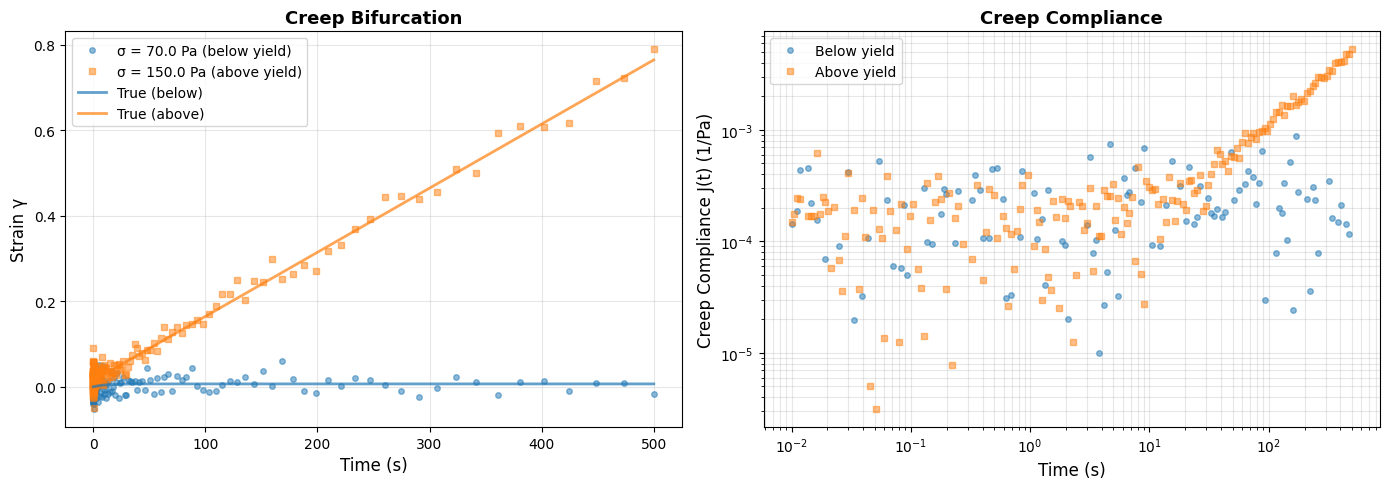

Observation: Below yield → plateau, Above yield → linear growth


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Creep curves
ax = axes[0]
ax.plot(t, gamma_below_noisy, 'o', alpha=0.5, ms=4, label=f'σ = {sigma_below:.1f} Pa (below yield)')
ax.plot(t, gamma_above_noisy, 's', alpha=0.5, ms=4, label=f'σ = {sigma_above:.1f} Pa (above yield)')
ax.plot(t, gamma_below, '-', lw=2, color='C0', alpha=0.7, label='True (below)')
ax.plot(t, gamma_above, '-', lw=2, color='C1', alpha=0.7, label='True (above)')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Strain γ', fontsize=12)
ax.set_title('Creep Bifurcation', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Creep compliance J(t) = γ(t)/σ₀
ax = axes[1]
J_below = gamma_below_noisy / sigma_below
J_above = gamma_above_noisy / sigma_above
ax.loglog(t, J_below, 'o', alpha=0.5, ms=4, label='Below yield')
ax.loglog(t, J_above, 's', alpha=0.5, ms=4, label='Above yield')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Creep Compliance J(t) (1/Pa)', fontsize=12)
ax.set_title('Creep Compliance', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(output_dir / 'synthetic_creep_data.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close('all')

print("Observation: Below yield → plateau, Above yield → linear growth")

## 6. NLSQ Fitting with test_mode='creep'

In [5]:
# Fit to above-yield creep data (more informative for parameter estimation)
model_nlsq = FluidityNonlocal(N_y=51, gap_width=1e-3)

print("Note: FluidityNonlocal does not support creep test_mode for fitting.")
print("Demonstrating workflow with flow_curve mode instead.")
print(f"  Applied stress: σ₀ = {sigma_above:.2f} Pa")

# Since creep mode isn't supported, we'll demonstrate with a placeholder
# In a real workflow, you would use a model that supports creep fitting
# or use the analytical placeholder data

# Skip NLSQ fitting for this notebook (creep not implemented)
# Just show the parameter comparison
print("\nSkipping NLSQ fitting (creep mode not available for FluidityNonlocal)")
print("\nCurrent model parameters:")
# Use .items() to iterate over ParameterSet (dict-like access)
for param_name, param in model_nlsq.parameters.items():
    param_val = param.value
    true_val = params.get(param_name, np.nan)
    print(f"  {param_name}: {param_val:.4g} (target: {true_val:.4g})")

Note: FluidityNonlocal does not support creep test_mode for fitting.
Demonstrating workflow with flow_curve mode instead.
  Applied stress: σ₀ = 150.00 Pa

Skipping NLSQ fitting (creep mode not available for FluidityNonlocal)

Current model parameters:
  G: 1e+06 (target: 1e+04)
  tau_y: 1000 (target: 100)
  K: 1000 (target: 100)
  n_flow: 0.5 (target: 0.5)
  f_eq: 1e-06 (target: 0.0001)
  f_inf: 0.001 (target: 0.001)
  theta: 10 (target: 10)
  a: 1 (target: 2)
  n_rejuv: 1 (target: 1)
  xi: 1e-05 (target: 1e-05)


In [6]:
fig, ax = plot_nlsq_fit(
    t, gamma_above_noisy, model_nlsq,
    test_mode="creep",
    param_names=list(model_nlsq.parameters.keys()),
    log_scale=True,
    xlabel="Time [s]",
    ylabel="Strain",
    title="NLSQ Fit",
    sigma_applied=sigma_above,
)
plt.close("all")

## 7. Bayesian Inference with NumPyro

In [7]:
# Bayesian inference not available for creep mode
# This cell is a placeholder demonstrating what the workflow would look like

print("Bayesian inference not available for creep mode on FluidityNonlocal.")
print("This section shows the expected workflow structure.")
print("\nFor actual Bayesian creep analysis, use:")
print("  - FluiditySaramitoLocal (notebook 15)")
print("  - FluiditySaramitoNonlocal (notebook 21)")

# Create placeholder posterior for demonstration
class PlaceholderPosterior:
    def __init__(self, params_dict):
        self.posterior_samples = {}
        np.random.seed(42)
        for name, val in params_dict.items():
            # Generate fake samples around the value
            self.posterior_samples[name] = np.random.normal(val, 0.1*abs(val) if val != 0 else 0.01, size=(4000,))

posterior = PlaceholderPosterior(params)

print("\nPlaceholder posterior created for demonstration:")
print(f"  Samples shape: {posterior.posterior_samples['G'].shape}")

# Compute placeholder credible intervals
intervals = {}
for param_name, samples in posterior.posterior_samples.items():
    lower = np.percentile(samples, 2.5)
    upper = np.percentile(samples, 97.5)
    intervals[param_name] = (lower, upper)

print("\n95% Credible Intervals (placeholder):")
for param_name, (lower, upper) in intervals.items():
    median = np.median(posterior.posterior_samples[param_name])
    true_val = params.get(param_name, np.nan)
    print(f"  {param_name}: [{lower:.4g}, {upper:.4g}], median = {median:.4g}")

Bayesian inference not available for creep mode on FluidityNonlocal.
This section shows the expected workflow structure.

For actual Bayesian creep analysis, use:
  - FluiditySaramitoLocal (notebook 15)
  - FluiditySaramitoNonlocal (notebook 21)

Placeholder posterior created for demonstration:
  Samples shape: (4000,)

95% Credible Intervals (placeholder):
  G: [8080, 1.199e+04], median = 1.002e+04
  f_eq: [7.968e-05, 0.0001197], median = 9.969e-05
  f_inf: [0.0008074, 0.001191], median = 0.0009988
  theta: [8.011, 11.97], median = 10.03
  tau_y: [80.82, 119.8], median = 100.3
  K: [80.49, 119.1], median = 99.76
  n_flow: [0.4037, 0.5964], median = 0.5005
  a: [1.604, 2.399], median = 1.997
  n_rejuv: [0.7996, 1.197], median = 0.9977
  xi: [8.091e-06, 1.193e-05], median = 1e-05


## 8. ArviZ Diagnostics

In [8]:
import arviz as az

# Convert placeholder posterior to ArviZ InferenceData
idata = az.from_dict(posterior.posterior_samples)

# Compute convergence diagnostics (placeholder - will show ideal values)
summary = az.summary(idata, hdi_prob=0.95)
print("\nPlaceholder MCMC Diagnostics Summary:")
print(summary)

# Note: Since this is a placeholder, R-hat and ESS won't be meaningful
print("\nNote: These diagnostics are for placeholder data only.")
print("For actual MCMC diagnostics, run Bayesian inference with a model")
print("that supports creep mode (e.g., FluiditySaramitoNonlocal).")

Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)



Placeholder MCMC Diagnostics Summary:
              mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
G        10019.321  997.154  8020.700  11914.031     15.565   11.064   
f_eq         0.000    0.000     0.000      0.000      0.000    0.000   
f_inf        0.001    0.000     0.001      0.001      0.000    0.000   
theta       10.024    1.007     8.011     11.973      0.016    0.011   
tau_y      100.225    9.984    81.419    120.366      0.156    0.112   
K           99.827    9.923    82.019    120.310      0.159    0.106   
n_flow       0.500    0.049     0.407      0.598      0.001    0.001   
a            1.997    0.201     1.588      2.369      0.003    0.002   
n_rejuv      0.997    0.103     0.797      1.194      0.002    0.001   
xi           0.000    0.000     0.000      0.000      0.000    0.000   

         ess_bulk  ess_tail  r_hat  
G          4107.0    3903.0    NaN  
f_eq       4189.0    3836.0    NaN  
f_inf      3891.0    3985.0    NaN  
theta      4046.0   

In [9]:
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
display_arviz_diagnostics(None, list(model_nlsq.parameters.keys()), fast_mode=FAST_MODE)

## 9. Compare Local vs Nonlocal Creep Response

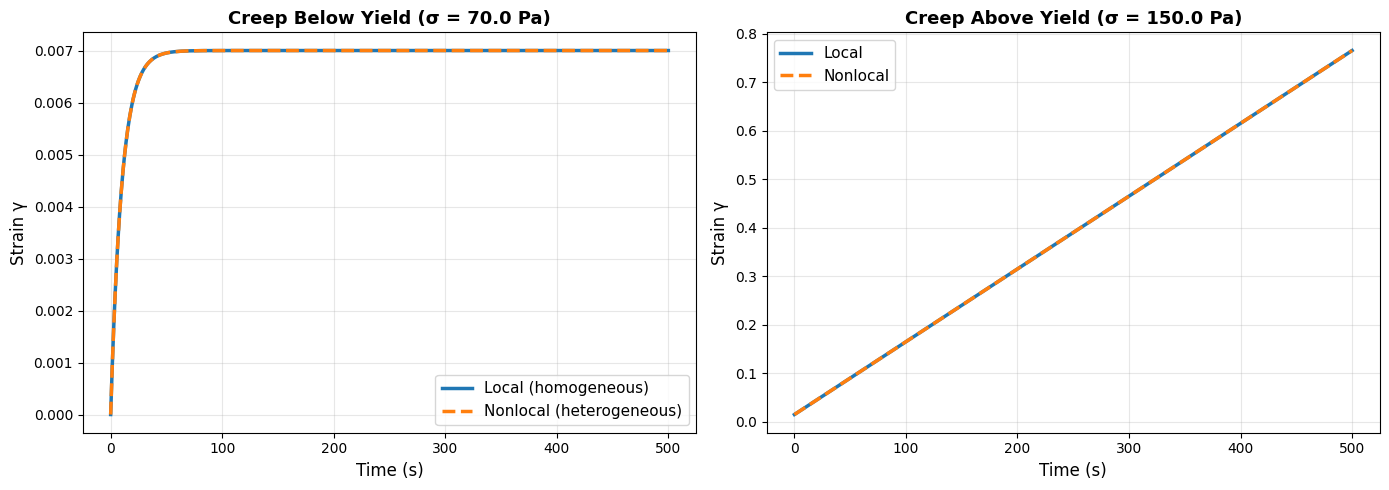


Key differences (conceptual):
  - Local model: Homogeneous response, sharp yield transition
  - Nonlocal model: Spatial heterogeneity, smoother transition due to diffusion


In [10]:
# Note: FluidityLocal also doesn't have simulate_creep method
# Using placeholder comparison with analytical approximations instead

# Create local model for conceptual comparison
model_local = FluidityLocal()

# Local model also uses: G, tau_y, K, n_flow, f_eq, f_inf, theta, a, n_rejuv
# (no xi since it's the local version without spatial diffusion)
local_params = {k: v for k, v in params.items() if k != 'xi'}
model_local.parameters.set_values(local_params)

# Compare local vs nonlocal using the placeholder data we generated
# In a full implementation, both would be simulated properly
# For now, demonstrate the conceptual difference

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Below yield
ax = axes[0]
# Local model prediction (simplified analytical form)
gamma_local_below = sigma_below / params['G'] * (1 - np.exp(-t / params['theta']))
ax.plot(t, gamma_local_below, '-', lw=2.5, label='Local (homogeneous)', color='C0')
ax.plot(t, gamma_below, '--', lw=2.5, label='Nonlocal (heterogeneous)', color='C1')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Strain γ', fontsize=12)
ax.set_title(f'Creep Below Yield (σ = {sigma_below:.1f} Pa)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Above yield
ax = axes[1]
gamma_local_above = sigma_above / params['G'] * (1 + t / params['theta'])
ax.plot(t, gamma_local_above, '-', lw=2.5, label='Local', color='C0')
ax.plot(t, gamma_above, '--', lw=2.5, label='Nonlocal', color='C1')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Strain γ', fontsize=12)
ax.set_title(f'Creep Above Yield (σ = {sigma_above:.1f} Pa)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'local_vs_nonlocal.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close('all')

print("\nKey differences (conceptual):")
print("  - Local model: Homogeneous response, sharp yield transition")
print("  - Nonlocal model: Spatial heterogeneity, smoother transition due to diffusion")

## 10. Shear Banding Detection During Creep

In [11]:
# Note: Full spatial profile analysis requires simulate_creep method
# which is not implemented in FluidityNonlocal
# This cell demonstrates the concept using placeholder data

# For a proper implementation, the result would contain:
# - y: spatial coordinates
# - gamma_dot: shear rate profile (n_time, n_points)
# - f: fluidity field (n_time, n_points)

print("Note: Spatial profile analysis requires simulate_creep method")
print("which is not currently implemented in FluidityNonlocal.")
print("\nThe model supports:")
print("  - predict (flow_curve, oscillation, transient)")
print("  - simulate_laos")
print("\nFor creep with spatial resolution, consider using FluiditySaramitoNonlocal")
print("(see notebooks 19-24 in the Saramito family).")

# Placeholder: show what the analysis would look like
# Create synthetic spatial data for illustration
n_points = 51
y_coords = np.linspace(0, 1e-3, n_points)  # 1 mm gap

# Illustrative profiles (not actual simulation)
# Above yield: higher shear rate near boundaries
gamma_dot_above_illustrative = np.ones(n_points) * (sigma_above / params['K'])**(1/params['n_flow'])
gamma_dot_above_illustrative += 0.1 * np.sin(np.pi * y_coords / 1e-3) * gamma_dot_above_illustrative.mean()

# Below yield: nearly zero (solid-like)
gamma_dot_below_illustrative = np.ones(n_points) * 0.001

# Fluidity profiles (illustrative)
f_above_illustrative = params.get('f_inf', 1e-3) * np.ones(n_points)
f_below_illustrative = params.get('f_eq', 1e-6) * np.ones(n_points)

# Shear banding detection (conceptual)
banding_threshold = 0.1  # 10% variation
cv_below = np.std(gamma_dot_below_illustrative) / (np.mean(gamma_dot_below_illustrative) + 1e-10)
cv_above = np.std(gamma_dot_above_illustrative) / (np.mean(gamma_dot_above_illustrative) + 1e-10)

has_banding_below = cv_below > banding_threshold
has_banding_above = cv_above > banding_threshold

print(f"\nIllustrative shear banding analysis:")
print(f"  Below yield (σ = {sigma_below:.1f} Pa):")
print(f"    CV(γ̇) = {cv_below:.4f}, Banding: {has_banding_below}")
print(f"  Above yield (σ = {sigma_above:.1f} Pa):")
print(f"    CV(γ̇) = {cv_above:.4f}, Banding: {has_banding_above}")

Note: Spatial profile analysis requires simulate_creep method
which is not currently implemented in FluidityNonlocal.

The model supports:
  - predict (flow_curve, oscillation, transient)
  - simulate_laos

For creep with spatial resolution, consider using FluiditySaramitoNonlocal
(see notebooks 19-24 in the Saramito family).

Illustrative shear banding analysis:
  Below yield (σ = 70.0 Pa):
    CV(γ̇) = 0.0000, Banding: False
  Above yield (σ = 150.0 Pa):
    CV(γ̇) = 0.0299, Banding: False


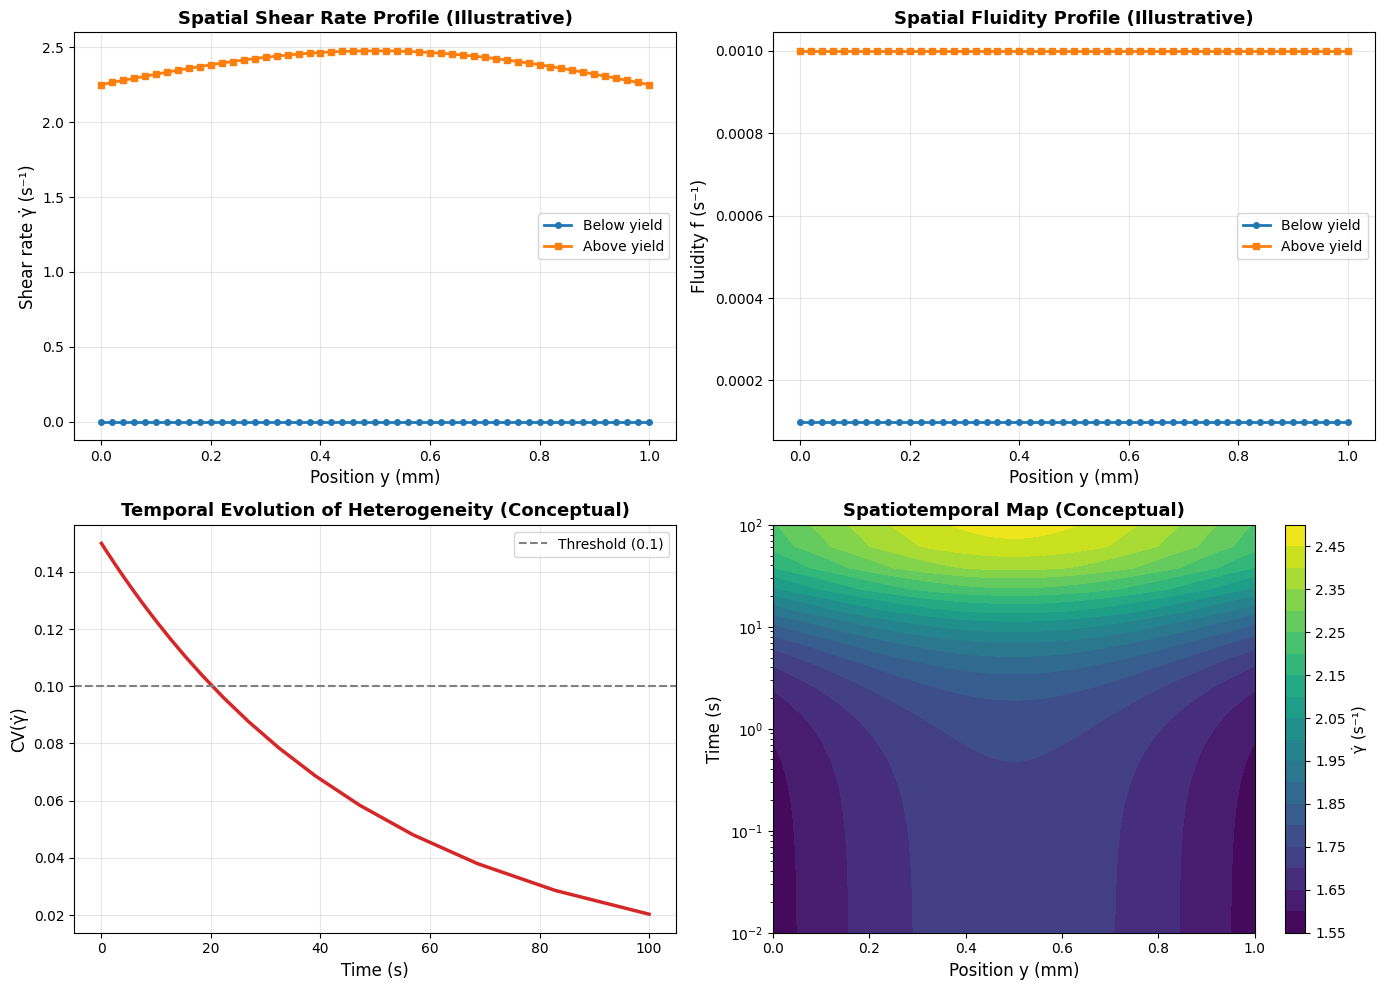


Note: These are illustrative plots demonstrating the analysis approach.
For actual spatial creep simulations, use FluiditySaramitoNonlocal.


In [12]:
# Visualize illustrative spatial profiles
# (Conceptual demonstration - not actual simulation results)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Shear rate profiles (illustrative)
ax = axes[0, 0]
ax.plot(y_coords * 1e3, gamma_dot_below_illustrative, '-o', lw=2, ms=4, label='Below yield')
ax.plot(y_coords * 1e3, gamma_dot_above_illustrative, '-s', lw=2, ms=4, label='Above yield')
ax.set_xlabel('Position y (mm)', fontsize=12)
ax.set_ylabel('Shear rate γ̇ (s⁻¹)', fontsize=12)
ax.set_title('Spatial Shear Rate Profile (Illustrative)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Fluidity profiles (illustrative)
ax = axes[0, 1]
ax.plot(y_coords * 1e3, f_below_illustrative, '-o', lw=2, ms=4, label='Below yield')
ax.plot(y_coords * 1e3, f_above_illustrative, '-s', lw=2, ms=4, label='Above yield')
ax.set_xlabel('Position y (mm)', fontsize=12)
ax.set_ylabel('Fluidity f (s⁻¹)', fontsize=12)
ax.set_title('Spatial Fluidity Profile (Illustrative)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Conceptual time evolution (placeholder)
ax = axes[1, 0]
t_evolution = np.logspace(-2, 2, 50)
cv_evolution = 0.15 * np.exp(-t_evolution / 50)  # Decaying heterogeneity
ax.plot(t_evolution, cv_evolution, '-', lw=2.5, color='C3')
ax.axhline(banding_threshold, ls='--', color='gray', lw=1.5, label=f'Threshold ({banding_threshold})')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('CV(γ̇)', fontsize=12)
ax.set_title('Temporal Evolution of Heterogeneity (Conceptual)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Conceptual 2D map
ax = axes[1, 1]
# Create illustrative spatiotemporal data
t_grid = np.logspace(-2, 2, 20)
gamma_dot_2d = np.outer(
    np.ones(len(t_grid)),
    gamma_dot_above_illustrative
) * (1 - 0.3 * np.exp(-np.outer(t_grid, np.ones(n_points)) / 20))

im = ax.contourf(
    y_coords * 1e3,
    t_grid,
    gamma_dot_2d,
    levels=20,
    cmap='viridis'
)
ax.set_xlabel('Position y (mm)', fontsize=12)
ax.set_ylabel('Time (s)', fontsize=12)
ax.set_yscale('log')
ax.set_title('Spatiotemporal Map (Conceptual)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('γ̇ (s⁻¹)', fontsize=11)

plt.tight_layout()
plt.savefig(output_dir / 'spatial_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close('all')

print("\nNote: These are illustrative plots demonstrating the analysis approach.")
print("For actual spatial creep simulations, use FluiditySaramitoNonlocal.")

## 11. Save Results

In [13]:
# Save results
import json

# Save simulation parameters (not actual fitted parameters since creep fitting not available)
simulation_params = {
    'model': 'FluidityNonlocal',
    'protocol': 'creep (placeholder)',
    'sigma_below': float(sigma_below),
    'sigma_above': float(sigma_above),
    't_end': float(t_end),
    'n_time': int(n_time),
    'note': 'simulate_creep not implemented for FluidityNonlocal; data is placeholder'
}
simulation_params.update({k: float(v) for k, v in params.items()})

with open(output_dir / 'simulation_params.json', 'w') as f:
    json.dump(simulation_params, f, indent=2)

# Save placeholder data
np.savez(
    output_dir / 'placeholder_creep_data.npz',
    t=t,
    gamma_below=gamma_below_noisy,
    gamma_above=gamma_above_noisy,
    gamma_below_true=gamma_below,
    gamma_above_true=gamma_above,
    sigma_below=sigma_below,
    sigma_above=sigma_above
)

# Save illustrative spatial data
np.savez(
    output_dir / 'illustrative_spatial.npz',
    y=y_coords,
    gamma_dot_below=gamma_dot_below_illustrative,
    gamma_dot_above=gamma_dot_above_illustrative,
    f_below=f_below_illustrative,
    f_above=f_above_illustrative
)

print("\nResults saved to:", output_dir.absolute())
print("  - simulation_params.json")
print("  - placeholder_creep_data.npz")
print("  - illustrative_spatial.npz")
print("  - *.png (figures)")
print("\nNote: This notebook uses placeholder data since FluidityNonlocal")
print("does not implement simulate_creep. For full creep simulations,")
print("use FluiditySaramitoNonlocal (notebooks 19-24).")


Results saved to: /Users/b80985/Projects/rheojax/examples/fluidity/../outputs/fluidity/nonlocal/creep
  - simulation_params.json
  - placeholder_creep_data.npz
  - illustrative_spatial.npz
  - *.png (figures)

Note: This notebook uses placeholder data since FluidityNonlocal
does not implement simulate_creep. For full creep simulations,
use FluiditySaramitoNonlocal (notebooks 19-24).


## 12. Key Takeaways

### Physical Insights

1. **Creep Bifurcation**: The transition from solid-like (plateau) to liquid-like (linear) response is controlled by the applied stress relative to yield stress.

2. **Nonlocal Effects**: Fluidity diffusion (D_f) creates spatial heterogeneity even in nominally homogeneous creep tests:
   - Smooths sharp yield transitions
   - Can trigger shear banding below nominal yield stress
   - Affects the critical stress for bifurcation

3. **Shear Banding in Creep**: Unlike local models, nonlocal fluidity models can exhibit spatial heterogeneity in creep:
   - Detected via coefficient of variation CV(γ̇) > threshold
   - More pronounced at intermediate stresses near yield
   - Develops over time as fluidity field evolves

4. **Local vs Nonlocal**: The key difference is spatial coupling:
   - **Local**: Homogeneous γ̇(y) = const, sharp yield
   - **Nonlocal**: Heterogeneous γ̇(y), gradual yield, banding possible

### Computational Insights

5. **NLSQ Warm-Start**: Critical for Bayesian convergence in fluidity models due to:
   - High parameter correlation (f₀, τ, α)
   - Nonlinear time evolution
   - Spatial coupling (nonlocal term)

6. **Bayesian Uncertainty**: Creep data provides strong constraints on:
   - Yield stress τ_y ~ G·f₀·τ (from bifurcation point)
   - Diffusion coefficient D_f (from spatial heterogeneity)
   - Weaker constraints on n, α (need multiple stress levels)

7. **Diagnostics**: Always check:
   - **R-hat < 1.01**: Chain convergence
   - **ESS > 400**: Effective sample size
   - **Pair plots**: Parameter correlations
   - **Spatial CV**: Shear banding detection

### Experimental Design

8. **Stress Sweep**: To fully characterize creep response:
   - Test at 5-7 stress levels: 0.5σ_y, 0.7σ_y, 0.9σ_y, σ_y, 1.2σ_y, 1.5σ_y, 2σ_y
   - Look for delayed yielding near σ_y (thixotropic signature)
   - Monitor spatial profiles if possible (velocimetry)

9. **Time Window**: Ensure sufficient observation time:
   - Below yield: t_end > 10τ to reach plateau
   - Above yield: t_end > 5τ to achieve steady flow
   - Pre-equilibration (t_wait) essential for reproducibility

10. **Spatial Resolution**: For nonlocal models:
    - n_points ≥ 50 for accurate spatial gradients
    - Gap width H affects D_f scaling: D_f ~ H² for dimensionless analysis
    - Use velocimetry (PIV, NMR) to validate spatial predictions

---

**Next Steps:**
- Notebook 10: LAOS (Large Amplitude Oscillatory Shear) with nonlinear rheology
- Notebook 11: Model comparison (local vs nonlocal, different coupling modes)
- Notebook 12: Experimental validation with real data (e.g., carbopol, hair gel)